# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [262]:
# Visualizations will be shown in the notebook.
%matplotlib inline

import os
from datetime import datetime 
import collections
import random
import pickle

import math

import numpy as np
from numpy import genfromtxt
import numpy.ma as ma
import pandas as pd

import tensorflow as tf
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from skimage import exposure

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2

from PIL import Image

In [2]:

def show_image(image, cmap=None):
    
    if(cmap == 'gray'):
        plt.figure(figsize=(5,5))
        plt.imshow(image, cmap='gray')
    
    else:
        plt.figure(figsize=(5,5))
        plt.imshow(image)


def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    # Brightness 
    
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    img = augment_brightness_camera_images(img)
    
    return img


def load_pickle(filename, directory='.'):   
    with open(filename, 'rb') as f:
         data = pickle.load(f)
    return data


def save_pickle(dataset, filename, keys = "features", directory='.'):

    pickle_file = filename
    
    try:
        f = open(pickle_file,'wb+')
        save = {
#            "features": X_train
            "features": dataset
    }
  
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    except Exception as e:
          print('Unable to save data to', pickle_file, ':', e)

            
def make_fakes(data,no_of_fakes):
    
    data_no = len(data) * no_of_fakes
    
    new_data = []
           
    for index in range(data.shape[0]):
    
        for fake in range(no_of_fakes):
#           print(data[index])
            
            fake = transform_image(data[index],20,10,5)
#           print("fake shape %s" % str(fake.shape))
#           print(type(fake))
            
            new_data.append(fake)        
                       
    return new_data

def make_fakes_labels(data,no_of_fakes):
    data_no = len(data)
    
    new_data = []
    
    for index in range(data.shape[0]):
        
        for fake in range(no_of_fakes):
            
            fake = data[index]
            
            new_data.append(fake)
            
    return new_data
    

def list_to_numpy(list_data):
    
    return np.array(list_data)


def convert_gray_with_adapthist(X, y = None):
    #Convert to grayscale, e.g. single Y channel
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
    
 
      
    # Apply localized histogram localization  
    for i in range(X.shape[0]):
        X[i] = exposure.equalize_adapthist(X[i])
        
    print("y is %s" % y)
        
    if y is not None:  
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(43)[y]
        # Shuffle the data
        X, y = shuffle(X, y)

    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y


def load_pickle_with_fakes(orignal_pickle,no_of_fakes, directory='.'):
    
    pickle_file = orignal_pickle
    
    original = load_pickle(pickle_file)
    
    X_train = original['features']
    
    fakes = make_fakes(X_train,no_of_fakes)
    
    X_train_norm = list_to_numpy(fakes)
    
    
    save_pickle(X_train_norm,"X_train_fake.p")

    data_norm = load_pickle('X_train_fake.p')
    
    # TODO: Load the label data to the variable y_train
    y_train = original['labels']
    
    fakes_label = make_fakes_labels(y_train,5)
    
    y_train_norm = list_to_numpy(fakes_label)
    
    save_pickle(y_train_norm,"y_train_fake.p")

    label_norm = load_pickle('y_train_fake.p')
    
    return data_norm, label_norm

def split_data(data, label, split = 0.3):
    
    X_train, X_valid, y_train, y_valid = train_test_split(
    data,
    label,
    test_size=split,
    random_state=832289)
    
    return X_train, X_valid, y_train, y_valid


def load_resized_images_in_directory(width,height,dirname):
    
    image_list = os.listdir(dirname)

    y_data = np.array(image_list)
    y_data2 = np.char.rstrip(y_data,'.jpg')
    y_web = y_data2.astype(np.uint8)
    
    X_web = np.array([cv2.resize(np.array(mpimg.imread(imagedir + fname)),(32,32)) 
                  for fname in image_list])
    
    return X_web, y_web
    

def resize_image(image, width, height):
    
    return cv2.resize(np.array(image),(width,height))

def load_images_in_directory(dirname):
    
    image_list = os.listdir(dirname)

    y_data = np.array(image_list)
    y_data2 = np.char.rstrip(y_data,'.jpg')
    y_web = y_data2.astype(np.uint8)

#    print(y_train[:5])

#    print(y_web[:])
    
    X_web = np.array([mpimg.imread(imagedir + fname) for fname in image_list])
    
    return X_web, y_web

def save_history(params, directory='.'):
    
    filename = 'history.txt'
    
    with open(filename,"w") as file:
        file.write("Train\n")
        file.write(str(datetime.now())+"\n")
        
        file.write(str(params)+"\n")
        
        file.write("Train_with_fakes\n")
        file.close()

        
def load_pickle_with_supplement(orignal_pickle,no_of_fakes, directory='.'):
    
    pickle_file = orignal_pickle
    
    original = load_pickle(pickle_file)
    
    X_train = original['features']
    
    fakes = make_fakes(X_train,no_of_fakes)
    
    X_train_norm = list_to_numpy(fakes)
    
    
    save_pickle(X_train_norm,"X_train_fake.p")

    data_norm = load_pickle('X_train_fake.p')
    
    # TODO: Load the label data to the variable y_train
    y_train = original['labels']
    
    fakes_label = make_fakes_labels(y_train,5)
    
    y_train_norm = list_to_numpy(fakes_label)
    
    save_pickle(y_train_norm,"y_train_fake.p")

    label_norm = load_pickle('y_train_fake.p')
    
    return data_norm, label_norm

In [79]:
y_train_gray = X_train_original['labels']

print(y_train_gray > 10)

b = y_train_gray >20
y_train_gray[b]

np.delete(arr, 1, 0)

[False False False ...,  True  True  True]


array([21, 21, 21, ..., 42, 42, 42], dtype=uint8)

In [3]:
X_train_original = load_pickle('train.p')
data = X_train_original['features']
X_train_gray,_ = convert_gray_with_adapthist(data)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


y is None


In [4]:
y_train_gray = X_train_original['labels']
print(y_train_gray[10])

0


In [247]:
test = load_pickle('test.p')
data_test = test['features']
y_test = test['labels']

X_test,_ = convert_gray_with_adapthist(data_test)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


y is None


In [6]:

from sklearn.utils import shuffle


X_train_gray, y_train_gray = shuffle(X_train_gray, y_train_gray) 
X_test, y_test = shuffle(X_test, y_test) 


In [7]:

X_train, X_valid, y_train, y_valid = split_data(X_train_gray,y_train_gray,split = 0.3)

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)
n_train_label = len(y_train)

# TODO: Number of testing examples.
n_valid = len(X_valid)
n_valid_label = len(y_valid)


print("Number of training examples =", n_train)
print(n_train_label )
print("Number of validation examples =", n_valid)
print(n_valid_label)


Number of training examples = 27446
27446
Number of validation examples = 11763
11763


In [77]:
print(len([n.name for n in tf.get_default_graph().as_graph_def().node]))

0


In [78]:
tf.reset_default_graph()
print(len([n.name for n in tf.get_default_graph().as_graph_def().node]))

0


In [42]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

"""

from tensorflow.contrib.layers import flatten


def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    keep_prob = 0.6
    keep_prob_fc = 0.7
    
    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 8), mean = mu, stddev = sigma),name="w1")
    conv1_b = tf.Variable(tf.zeros(8),name="b1")
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # SOLUTION: Activation.
    conv1_relu = tf.nn.relu(conv1)
    conv1_drop = tf.nn.dropout(conv1_relu, keep_prob)

    # SOLUTION: Pooling. Input = 32x32x16. Output = 16x16x16.
    conv1_pool = tf.nn.max_pool(conv1_drop, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # SOLUTION: Layer 2: Convolutional. Input = 16x16x16. Output = 16x16x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 8, 16), mean = mu, stddev = sigma),name="w2")
    conv2_b = tf.Variable(tf.zeros(16),name="b2")
    conv2   = tf.nn.conv2d(conv1_pool, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # SOLUTION: Activation.
    conv2_relu = tf.nn.relu(conv2)
    conv2_drop = tf.nn.dropout(conv2_relu, keep_prob)

    # SOLUTION: Pooling. Input = 16x16x32. Output = 8x8x32.
    conv2_pool = tf.nn.max_pool(conv2_drop, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma),name="w3")
    conv3_b = tf.Variable(tf.zeros(32),name="b3")
    conv3   = tf.nn.conv2d(conv2_pool, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b
    
    # SOLUTION: Activation.
    conv3_relu = tf.nn.relu(conv3)
    conv3_drop = tf.nn.dropout(conv3_relu, keep_prob)

    # SOLUTION: Pooling. Input = 16x16x32. Output = 8x8x32.
    conv3_pool = tf.nn.max_pool(conv3_drop, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # SOLUTION: Flatten. Input = 8x8x32. Output = 2048.
#    fc0   = flatten(conv2_pool)
    
    conv1_pool_flat = tf.reshape( conv1_pool, [-1, 16 * 16 * 8])
    conv2_pool_flat = tf.reshape( conv2_pool, [-1, 8 * 8 * 16])
    conv3_pool_flat = tf.reshape( conv3_pool, [-1, 4 * 4 * 32])
    fc0 = tf.concat(1,[ conv1_pool_flat , conv2_pool_flat,conv3_pool_flat])
    
    
    # SOLUTION: Layer 3: Fully Connected. Input = 2048. Output = 120.
    # SOLUTION: Layer 3: Fully Connected. Input = 6144. Output = 120.
     # SOLUTION: Layer 3: Fully Connected. Input = 3072. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(3584, 1024), mean = mu, stddev = sigma),name="fc1_w1")
    fc1_b = tf.Variable(tf.zeros(1024),name="fc1_b1")
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
#    fc1   = tf.matmul(fc0, fc1_weights) + fc1_bias
    
    # SOLUTION: Activation.
    fc1_relu    = tf.nn.relu(fc1)
    fc1_drop = tf.nn.dropout(fc1_relu, keep_prob_fc)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 43.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024, 43), mean = mu, stddev = sigma),name="fc2_w2")
  
    fc2_b  = tf.Variable(tf.zeros(43),name="fc2_b2")
    logits  = tf.matmul(  fc1_drop, fc2_W) + fc2_b

    return logits
"""

'\n\nfrom tensorflow.contrib.layers import flatten\n\n\ndef LeNet(x):    \n    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer\n    mu = 0\n    sigma = 0.1\n    keep_prob = 0.6\n    keep_prob_fc = 0.7\n    \n    \n    \n    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x16.\n    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 8), mean = mu, stddev = sigma),name="w1")\n    conv1_b = tf.Variable(tf.zeros(8),name="b1")\n    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding=\'SAME\') + conv1_b\n\n    # SOLUTION: Activation.\n    conv1_relu = tf.nn.relu(conv1)\n    conv1_drop = tf.nn.dropout(conv1_relu, keep_prob)\n\n    # SOLUTION: Pooling. Input = 32x32x16. Output = 16x16x16.\n    conv1_pool = tf.nn.max_pool(conv1_drop, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=\'SAME\')\n\n    # SOLUTION: Layer 2: Convolutional. Input = 16x16x16. Output = 16x16x32.\n    conv2_W = tf.Variab

In [251]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    keep_prob = 0.6
    keep_prob_fc = 0.7
    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 16), mean = mu, stddev = sigma),name="w1")
    conv1_b = tf.Variable(tf.zeros(16),name="b1")
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # SOLUTION: Activation.
    conv1_relu = tf.nn.relu(conv1)
    conv1_drop = tf.nn.dropout(conv1_relu, keep_prob)

    # SOLUTION: Pooling. Input = 32x32x16. Output = 16x16x16.
    conv1_pool = tf.nn.max_pool(conv1_drop, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # SOLUTION: Layer 2: Convolutional. Input = 16x16x16. Output = 16x16x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma),name="w2")
    conv2_b = tf.Variable(tf.zeros(32),name="b2")
    conv2   = tf.nn.conv2d(conv1_pool, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # SOLUTION: Activation.
    conv2_relu = tf.nn.relu(conv2)
    conv2_drop = tf.nn.dropout(conv2_relu, keep_prob)

    # SOLUTION: Pooling. Input = 16x16x32. Output = 8x8x32.
    conv2_pool = tf.nn.max_pool(conv2_drop, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # SOLUTION: Flatten. Input = 8x8x32. Output = 2048.
#    fc0   = flatten(conv2_pool)
    
    conv1_pool_flat = tf.reshape( conv1_pool, [-1, 16 * 16 * 16])
    conv2_pool_flat = tf.reshape( conv2_pool, [-1, 8 * 8 * 32])
    fc0 = tf.concat(1,[ conv1_pool_flat , conv2_pool_flat])
    
    
    # SOLUTION: Layer 3: Fully Connected. Input = 2048. Output = 120.
    # SOLUTION: Layer 3: Fully Connected. Input = 6144. Output = 120.
     # SOLUTION: Layer 3: Fully Connected. Input = 3072. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(6144, 1200), mean = mu, stddev = sigma),name="fc1_w1")
    fc1_b = tf.Variable(tf.zeros(1200),name="fc1_b1")
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
#    fc1   = tf.matmul(fc0, fc1_weights) + fc1_bias
    
    # SOLUTION: Activation.
    fc1_relu    = tf.nn.relu(fc1)
    fc1_drop = tf.nn.dropout(fc1_relu, keep_prob_fc)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 43.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1200, 43), mean = mu, stddev = sigma),name="fc2_w2")
  
    fc2_b  = tf.Variable(tf.zeros(43),name="fc2_b2")
    logits  = tf.matmul(  fc1_drop, fc2_W) + fc2_b
    
      # SOLUTION: Activation.
#    fc2_relu    = tf.nn.relu(fc2)
    
    
      # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 43.
#    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma),name="fc3_w3")
#    fc3_b  = tf.Variable(tf.zeros(43),name="fc3_b3")
#    logits    = tf.matmul( fc2_relu, fc3_W) + fc3_b

    return logits

In [252]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [253]:
rate = 0.001

logits = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(tf.nn.l2_normalize(logits, dim=0), one_hot_y)
#loss_operation = tf.reduce_mean(tf.nn.l2_loss(cross_entropy))
loss_operation = tf.reduce_mean((cross_entropy))


#defining training operation and debugging functions
optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
topk_operation = tf.nn.top_k(tf.nn.softmax(logits), k=5)
y_value = tf.argmax(one_hot_y, 1)

In [254]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

EPOCHS = 5
BATCH_SIZE = 128

# hyper parameters to be remained.

# Initializing the variables
init = tf.global_variables_initializer()

# Calling tf.train.Saver
saver = tf.train.Saver()

In [255]:
# defining evaluation function 

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        
#       print(loss)
        total_loss += loss
        total_accuracy += (accuracy * len(batch_x))
    return total_loss  , total_accuracy / num_examples

def evaluate_topk(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        topk_values, topk_indices = sess.run(topk_operation, feed_dict={x: batch_x, y: batch_y})
       
    return topk_values, topk_indices 


def evaluate_debugging(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss_val, acc_val, top_k = sess.run([loss_operation,correct_prediction,topk_operation], feed_dict={x: batch_x, y: batch_y})
        
#       print(loss)
#        total_loss += loss
#        total_accuracy += (accuracy * len(batch_x))
    return loss_val, acc_val, top_k,batch_x, batch_y


tf.add_to_collection("my_evaluate",evaluate)
tf.add_to_collection("my_evaluate_topk", evaluate_topk)

In [84]:
# trainning and saving trained model

debugger_images = []
debugger_labels = []

with tf.Session() as sess:
    sess.run(init)
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
             
        print("EPOCH {} ...".format(i+1))
        validation_loss, validation_accuracy = evaluate(X_valid, y_valid)
       
        print("Validation loss = {0:.3f}".format(validation_loss))
        print("Validation Accuracy = {0:.3f}".format(validation_accuracy))
        
        if(i == (EPOCHS-1) ):
            """
            if((offset+1) * BATCH_SIZE > num_examples):
                print("EPOCH {} ...".format(i+1))
                print("batch_y is %s " % batch_y)
                print("training loss = {0:.3f}".format(loss_val))
                print("training accuracy = %s" % acc_val)
                print("training loss, batch input data index  = %s" % np.where(acc_val == False)[0])
            
                
          #      print("input value is " %  str(y_wrong))
                
                
         #      print("top k = %s" % type(top_k))
                print("top k = %s" % top_k.indices)
                
                y_wrong_list = (np.where(acc_val == False)[0]).tolist()
                
                print("training loss list, batch input data index lists = %s" % y_wrong_list)
                
                print("training loss list, batch_y")
                for data in y_wrong_list:
                    
#                   print(batch_y[data])
                    debugger_labels.append(batch_y[data])
                
                
                y_wrong = ma.masked_array(batch_y, mask=np.array(acc_val, ndmin=2))
                
                print("training loss, visualization of input data")
                print(y_wrong)
                print(type(y_wrong.tolist))
                           
                print("training loss, top_k indices")
                for i in y_wrong_list:
                    
                    print(top_k.indices[i])
                    
                x_wrong_list = (np.where(acc_val == False)[0]).tolist()
                
                print("training loss list = %s" % x_wrong_list)
                
            #    print("batch_x is %s " % batch_x)
                
                for i in y_wrong_list:
                    debugger_images.append(batch_x[i])
           
            """
            test_loss,test_accuracy = evaluate(X_test, y_test)
          
            print("EPOCH {} ...".format(i+1))
            print("Test Loss = {:.3f}".format(test_loss))
            print("Test Accuracy = {:.3f}".format(test_accuracy))
        
    saver.save(sess, "./lenet/model.ckpt")
#    tf.train.export_meta_graph(filename='./lenet/model.meta')
   
    print("Model saved")

Training...
EPOCH 1 ...
Validation loss = 314.925
Validation Accuracy = 0.890
EPOCH 2 ...
Validation loss = 309.444
Validation Accuracy = 0.942
EPOCH 3 ...
Validation loss = 306.843
Validation Accuracy = 0.965
EPOCH 4 ...
Validation loss = 305.345
Validation Accuracy = 0.973
EPOCH 5 ...
Validation loss = 304.503
Validation Accuracy = 0.976
EPOCH 5 ...
Test Loss = 330.118
Test Accuracy = 0.940
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'function' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'function' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'function' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'function' object has no attribute 'name'
Model saved


In [256]:
print(len([n.name for n in tf.get_default_graph().as_graph_def().node]))
no_node_training = [n.name for n in tf.get_default_graph().as_graph_def().node]

608


In [257]:
print_tensors_in_checkpoint_file("./lenet/model.ckpt",tensor_name='')
#print_tensors_in_checkpoint_file(file_name='./lenet/model.ckpt', tensor_name='w1')

b1 (DT_FLOAT) [16]
b1/Adam (DT_FLOAT) [16]
b1/Adam_1 (DT_FLOAT) [16]
b2 (DT_FLOAT) [32]
b2/Adam (DT_FLOAT) [32]
b2/Adam_1 (DT_FLOAT) [32]
beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
fc1_b1 (DT_FLOAT) [1200]
fc1_b1/Adam (DT_FLOAT) [1200]
fc1_b1/Adam_1 (DT_FLOAT) [1200]
fc1_w1 (DT_FLOAT) [6144,1200]
fc1_w1/Adam (DT_FLOAT) [6144,1200]
fc1_w1/Adam_1 (DT_FLOAT) [6144,1200]
fc2_b2 (DT_FLOAT) [43]
fc2_b2/Adam (DT_FLOAT) [43]
fc2_b2/Adam_1 (DT_FLOAT) [43]
fc2_w2 (DT_FLOAT) [1200,43]
fc2_w2/Adam (DT_FLOAT) [1200,43]
fc2_w2/Adam_1 (DT_FLOAT) [1200,43]
w1 (DT_FLOAT) [3,3,1,16]
w1/Adam (DT_FLOAT) [3,3,1,16]
w1/Adam_1 (DT_FLOAT) [3,3,1,16]
w2 (DT_FLOAT) [3,3,16,32]
w2/Adam (DT_FLOAT) [3,3,16,32]
w2/Adam_1 (DT_FLOAT) [3,3,16,32]



---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [65]:
# restoring and (trainning and saving trained model) again

debugger_valid_images = []
debugger_valid_labels = []
print_cutoff = EPOCHS * 0.01

with tf.Session() as sess:
#with sess.as_default():
    sess.run(init)
    
    saver.restore(sess, "./lenet/model.ckpt")
    
    print("restored...")
    
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        X_valid, y_valid = shuffle(X_valid, y_valid)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        print("EPOCH {} ...".format(i+1))
#        print("training loss = {0:.3f}".format(loss_val))
      
        loss_val, acc_val, top_k,batch_x,batch_y = evaluate_debugging(X_valid, y_valid)
#        print("Validation Loss = {:.3f}".format( loss_val))
#        print("Validation Accuracy = {:.3f}".format(acc_val))
        
        if(print_cutoff < i <(EPOCHS-1)):
            print("EPOCH {} ...".format(i+1))
            print("training loss = {0:.3f}".format(loss_val))
            print("training accuracy = %s" % acc_val)
            print("training loss, batch input data index  = %s" % np.where(acc_val == False)[0])
           
            y_wrong_list = (np.where(acc_val == False)[0]).tolist()
                
            print("training loss list, batch input data index lists = %s" % y_wrong_list)
                
            y_wrong = ma.masked_array(batch_y, mask=np.array(acc_val, ndmin=2))
                
            print("training loss, visualization of input data")
            print(y_wrong)
                
            print("training loss, top_k indices")
            for i in y_wrong_list:
                    
                print(top_k.indices[i])
                    
            x_wrong_list = (np.where(acc_val == False)[0]).tolist()
                
            print("training loss list = %s" % x_wrong_list)
                
            #print("batch_x is %s " % batch_x)
            
            print("training loss list, batch_y")
            for data in y_wrong_list:
                    
                debugger_valid_labels.append(batch_y[data])
                
            for i in y_wrong_list:
                debugger_valid_images.append(batch_x[i])
        
        
        if(i == (EPOCHS-1) ):
          
            test_loss,test_accuracy = evaluate(X_test, y_test)
          
            print("EPOCH {} ...".format(i+1))
            print("Test Loss = {:.3f}".format(test_loss))
            print("Test Accuracy = {:.3f}".format(test_accuracy))
        
        print()

restored...
Training...
EPOCH 1 ...

EPOCH 2 ...
EPOCH 2 ...
training loss = 3.278
training accuracy = [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
training loss, batch input data index  = [20 46 59 71]
training loss list, batch input data index lists = [20, 46, 59, 71]
training loss, visualization of input data
[-- -- -- -- -- -- -- -- -- --

In [66]:
no_node_debugger = [n.name for n in tf.get_default_graph().as_graph_def().node]
print(len(no_node_debugger))

608


In [67]:
len([i for i, j in zip( no_node_training, no_node_debugger) if i == j])

608

In [89]:
print_tensors_in_checkpoint_file("./lenet/model.ckpt",tensor_name='')

b1 (DT_FLOAT) [16]
b1/Adam (DT_FLOAT) [16]
b1/Adam_1 (DT_FLOAT) [16]
b2 (DT_FLOAT) [32]
b2/Adam (DT_FLOAT) [32]
b2/Adam_1 (DT_FLOAT) [32]
beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
fc1_b1 (DT_FLOAT) [1200]
fc1_b1/Adam (DT_FLOAT) [1200]
fc1_b1/Adam_1 (DT_FLOAT) [1200]
fc1_w1 (DT_FLOAT) [6144,1200]
fc1_w1/Adam (DT_FLOAT) [6144,1200]
fc1_w1/Adam_1 (DT_FLOAT) [6144,1200]
fc2_b2 (DT_FLOAT) [43]
fc2_b2/Adam (DT_FLOAT) [43]
fc2_b2/Adam_1 (DT_FLOAT) [43]
fc2_w2 (DT_FLOAT) [1200,43]
fc2_w2/Adam (DT_FLOAT) [1200,43]
fc2_w2/Adam_1 (DT_FLOAT) [1200,43]
w1 (DT_FLOAT) [3,3,1,16]
w1/Adam (DT_FLOAT) [3,3,1,16]
w1/Adam_1 (DT_FLOAT) [3,3,1,16]
w2 (DT_FLOAT) [3,3,16,32]
w2/Adam (DT_FLOAT) [3,3,16,32]
w2/Adam_1 (DT_FLOAT) [3,3,16,32]



### Include an exploratory visualization of the dataset

In [60]:
print("validation error image labels")
print(debugger_valid_labels)

validation error image labels
[1, 9, 2, 3, 14, 20, 38, 5, 26]


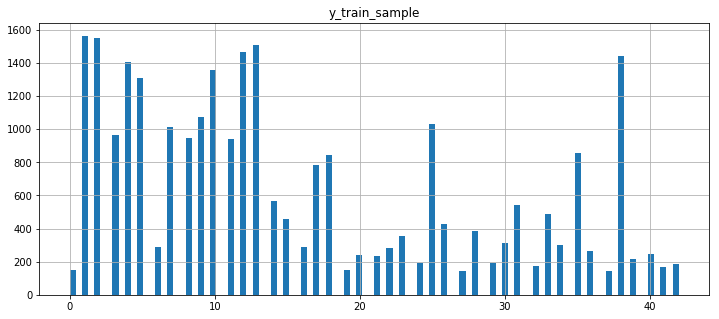

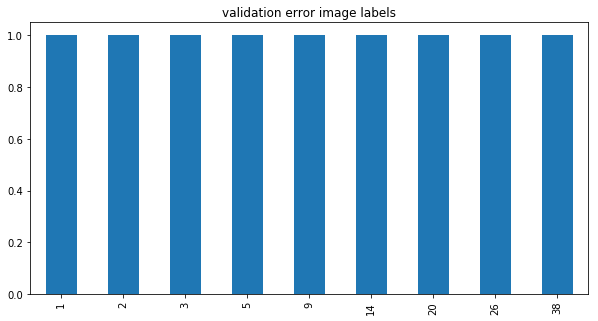

In [61]:
from collections import Counter
import operator
import matplotlib.pyplot as plt

distribution =pd.DataFrame({"y_train_sample":y_train})
distribution.hist(layout=(1,1),bins=100, figsize=(12,5))  

debugger_dic =  Counter(debugger_valid_labels)

#plt.bar(range(len(debugger_dic)), debugger_dic.values(), align='center')
#plt.xticks(range(len(debugger_dic)), debugger_dic.keys())
#plt.show()

df = pd.DataFrame([debugger_dic])
df = df.T

fig, axes = plt.subplots(nrows=1, ncols=1)
for i,c in enumerate(df.columns):
    df[c].plot(kind='bar',  figsize=(10, 5), title="validation error image labels")

validation error image labels
[41  3 34  1 20 26 28 38  8 11]
[8 2]


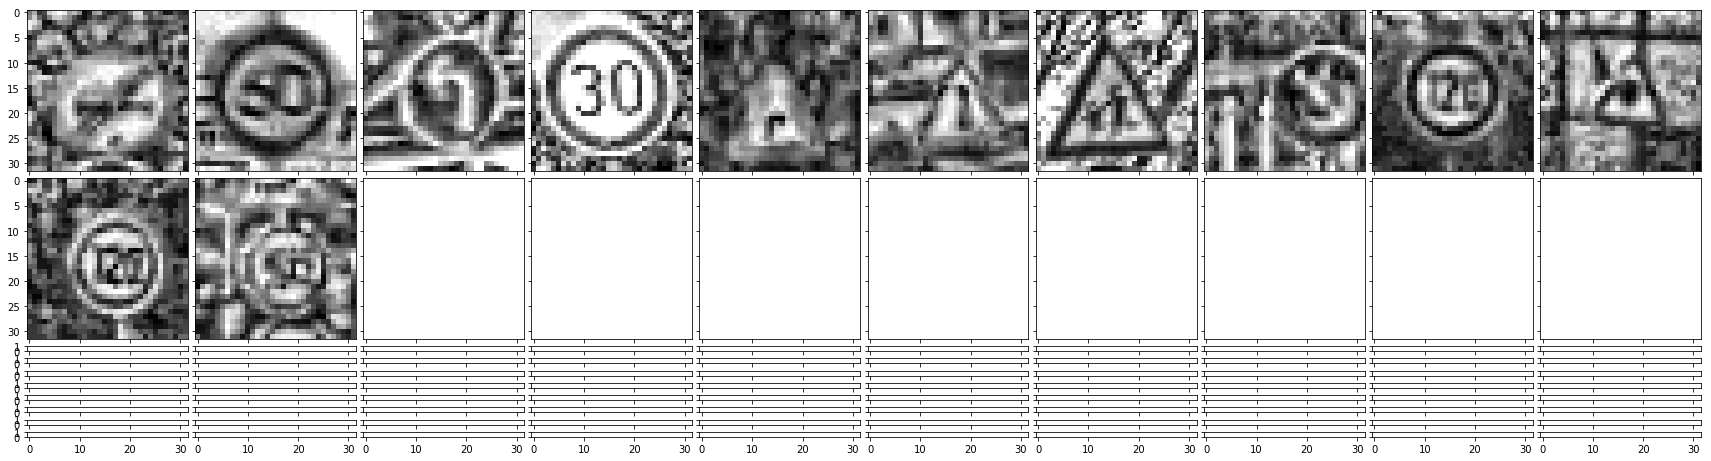

In [68]:
print("validation error image labels")
#print(debugger_valid_labels)

num_debugger = np.asarray(debugger_valid_labels)

#print(num_debugger.shape[0])

for i in range((math.ceil((num_debugger.shape[0])/10))):
    
    offset = i * 10
    print(num_debugger[offset:offset+10])


fig = plt.figure(1, (30., 30.))

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                  )

for index, image in enumerate(debugger_valid_images):
    gray = image.reshape(32,32)
    grid[index].imshow(gray, cmap="gray")
#    show_image(gray, cmap="gray")

plt.show()

(array([ 112.,  305.,  387.,  479.,  382.,  511.,  575.,  407.,  460.,
         450.,  459.,  425.,  409.,  485.,  376.,  412.,  326.,  360.,
         266.,  373.,  302.,  188.,  231.,  150.,  183.,  203.]),
 array([ 0.        ,  0.03846154,  0.07692308,  0.11538462,  0.15384615,
         0.19230769,  0.23076923,  0.26923077,  0.30769231,  0.34615385,
         0.38461538,  0.42307692,  0.46153846,  0.5       ,  0.53846154,
         0.57692308,  0.61538462,  0.65384615,  0.69230769,  0.73076923,
         0.76923077,  0.80769231,  0.84615385,  0.88461538,  0.92307692,
         0.96153846,  1.        ]),
 <a list of 26 Patch objects>)

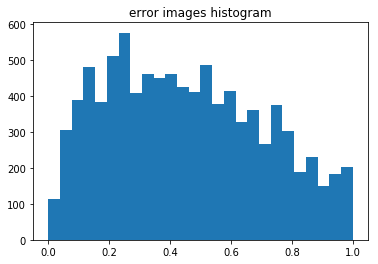

In [63]:
error_images = np.asarray(debugger_valid_images)

plt.title("error images histogram")
plt.hist(error_images.flatten(), bins='auto')

<class 'numpy.ndarray'>


(array([  535.,   447.,   941.,  1763.,  1414.,  1577.,  1542.,  2688.,
         1656.,  2422.,  2568.,  1821.,  1907.,  1976.,  2528.,  1947.,
         2083.,  1469.,  3354.,  1840.,  1718.,  2522.,  1916.,  2001.,
         1533.,  2599.,  1387.,  2394.,  2043.,  1820.,  1817.,  1451.,
         2358.,  1377.,  1724.,  1186.,  2639.,  1400.,  1342.,  1946.,
         1258.,  1268.,   950.,  1821.,  1192.,   979.,  1495.,   800.,
         1041.,   570.,  1127.,   643.,   564.,  3777.]),
 array([ 0.        ,  0.01851852,  0.03703704,  0.05555556,  0.07407407,
         0.09259259,  0.11111111,  0.12962963,  0.14814815,  0.16666667,
         0.18518519,  0.2037037 ,  0.22222222,  0.24074074,  0.25925926,
         0.27777778,  0.2962963 ,  0.31481481,  0.33333333,  0.35185185,
         0.37037037,  0.38888889,  0.40740741,  0.42592593,  0.44444444,
         0.46296296,  0.48148148,  0.5       ,  0.51851852,  0.53703704,
         0.55555556,  0.57407407,  0.59259259,  0.61111111,  0.62962963,

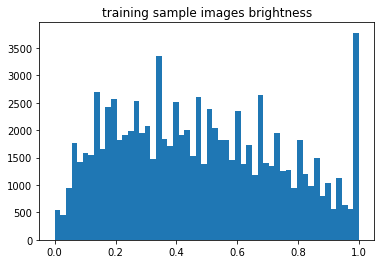

In [69]:
print(type(X_train))

def get_random_image(data, label):
   
    random_size = len(data)
    
    maybe_image = random.randint(0,random_size)
          
    return data[maybe_image]

def get_random_images(data, label, sample_no = 89):
    
    sample_locs = []
    sample_labels = []
    
    images = []
    
    for i in range(sample_no):
        
        image =  get_random_image(data, label)
        images.append(image)
        
    return images
        
test2 = get_random_images(X_train, y_train,sample_no = 89 )

plt.title("training sample images brightness")
plt.hist( np.asarray(test2).flatten(), bins='auto')

In [215]:
X_train_original = load_pickle('train.p')
data = X_train_original['features']
X_train_gray,_ = convert_gray_with_adapthist(data)


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


y is None


In [291]:
y_train_gray = X_train_original['labels']

def make_indexer(labels):
    
    indexer = []
    new_data = [] 
    new_labels = []
    
    x = collections.Counter(labels)

    value = 0

    for k, v in sorted(x.items()):
#        print(k)
#        print(v)
        value += v
        indexer.append(value)
        
    return indexer

def slice_few_image(data, indexer, cutoff=200):
     
    new_data = [] 
    new_labels = []

    for i in range (len(indexer)-1):
        
        if(i ==0 and (indexer[0] < cutoff)):
            
            for step in range(indexer[0]):
                new_labels.append(i)
                new_data.append(data[step])
        
        if(indexer[i+1] - indexer[i] < cutoff):
            
            for step in range(indexer[i+1] - indexer[i]):
            
                new_labels.append(i+1)
                new_data.append(data[indexer[i]+step])
                   
    return new_data, new_labels

test_indexer = make_indexer(y_train_gray)
#test_data , test_label =  slice_few_image(data, test_indexer, cutoff=400)
test_data , test_label =  slice_few_image(X_train_gray, test_indexer, cutoff=500)

"""
#print((data[2:4,:,:,:]).shape)
test = make_indexer(y_train_gray)
print("test %s" % test)

test_data , test_label =  slice_few_image(data, test, cutoff=400)
#print(test_label)
print(len(test_data))
print(len(test_label))

x = collections.Counter(test_label)
print(x)

test_images = list_to_numpy(test_data)

print(test_images.shape)

result = test_images[296]
print(result.shape)
show_image(result)
"""

'\n#print((data[2:4,:,:,:]).shape)\ntest = make_indexer(y_train_gray)\nprint("test %s" % test)\n\ntest_data , test_label =  slice_few_image(data, test, cutoff=400)\n#print(test_label)\nprint(len(test_data))\nprint(len(test_label))\n\nx = collections.Counter(test_label)\nprint(x)\n\ntest_images = list_to_numpy(test_data)\n\nprint(test_images.shape)\n\nresult = test_images[296]\nprint(result.shape)\nshow_image(result)\n'

In [278]:
def transform_image_test(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    # Brightness 
    
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
#    img = augment_brightness_camera_images(img)
    
    return img

In [279]:
print(len(test_data))
print(len(test_label))
print(type(test_data))

10499
10499
<class 'list'>


In [292]:
def make_fake_images(images_list, labels_list, copy_no=10):
    
    X_train_fake = []
    y_train_fake = []
    copy_no = copy_no
    
    for copy in range(copy_no):
        for index, image in  enumerate(images_list):
            image = transform_image_test(image,10,5,5)
            image =  image.reshape(image.shape + (1,)) 
            X_train_fake.append(image)
            y_train_fake.append(labels_list[index])
    return X_train_fake, y_train_fake

fake_images, fake_labels = make_fake_images(test_data,test_label,copy_no=5)

In [293]:
print(fake_images[0].shape)
print(fake_labels[0])

(32, 32, 1)
0


In [294]:
print(len(fake_images))
print(len(fake_labels))

X_train_fake = list_to_numpy(fake_images)
y_train_fake = list_to_numpy(fake_labels)
X_train = X_train_gray
y_train = y_train_gray

print(type(X_train_fake))
print(type(y_train_fake))
print(type(X_train))
print(type(y_train))

print(X_train_fake.shape)
print(y_train_fake.shape)
print(X_train.shape)
print(y_train.shape)

29850
29850
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(29850, 32, 32, 1)
(29850,)
(39209, 32, 32, 1)
(39209,)


In [295]:
X_train_original_fake = np.concatenate((X_train, X_train_fake), axis=0)

y_train_original_fake = np.concatenate((y_train, y_train_fake), axis=0)

print(X_train_original_fake.shape)
print(y_train_original_fake.shape)

(69059, 32, 32, 1)
(69059,)


In [296]:
X_train_plus, X_valid_plus, y_train_plus, y_valid_plus = split_data(X_train_original_fake,y_train_original_fake,split = 0.3)

In [32]:


X_train_fake = []
y_train_fake = []
copy_no = 100

for copy in range(copy_no):
    for index, image in  enumerate(debugger_valid_images):
        image = transform_image_test(image,10,5,5)
        image =  image.reshape(image.shape + (1,)) 
        X_train_fake.append(image)
        y_train_fake.append(debugger_valid_labels[index])
        
print(len(X_train_fake))

X_train_fake = list_to_numpy(X_train_fake)
y_train_fake = list_to_numpy(y_train_fake)
print(X_train_fake.shape)
print(y_train_fake.shape)

4100
(4100, 32, 32, 1)
(4100,)


In [297]:
from sklearn.utils import shuffle

X_train_plus, y_train_plus = shuffle(X_train_plus,y_train_plus) 
X_test, y_test = shuffle(X_test, y_test) 

In [299]:
# restoring and (trainning and saving trained model) again

EPOCHS = 100

debugger_valid_images = []
debugger_valid_labels = []
print_cutoff = EPOCHS * 0.05

with tf.Session() as sess:
    sess.run(init)
    
    saver.restore(sess, "./lenet/model.ckpt")
    
    print("restored...")
    
    num_examples = len(X_train_plus)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train_plus, y_train_plus = shuffle(X_train_plus, y_train_plus)
        X_valid_plus, y_valid_plus = shuffle(X_valid_plus, y_valid_plus)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_plus[offset:end], y_train_plus[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        print("EPOCH {} ...".format(i+1))
#        print("training loss = {0:.3f}".format(loss_val))
      
        loss_val, acc_val, top_k,batch_x,batch_y = evaluate_debugging(X_valid_plus, y_valid_plus)
#        print("Validation Loss = {:.3f}".format( loss_val))
#        print("Validation Accuracy = {:.3f}".format(acc_val))
        
        if(print_cutoff < i <(EPOCHS-1)):
            print("EPOCH {} ...".format(i+1))
            print("training loss = {0:.3f}".format(loss_val))
            print("training accuracy = %s" % acc_val)
            print("training loss, batch input data index  = %s" % np.where(acc_val == False)[0])
           
            y_wrong_list = (np.where(acc_val == False)[0]).tolist()
                
            print("training loss list, batch input data index lists = %s" % y_wrong_list)
                
            y_wrong = ma.masked_array(batch_y, mask=np.array(acc_val, ndmin=2))
                
            print("training loss, visualization of input data")
            print(y_wrong)
                
            print("training loss, top_k indices")
            for i in y_wrong_list:
                    
                print(top_k.indices[i])
                    
            x_wrong_list = (np.where(acc_val == False)[0]).tolist()
                
            print("training loss list = %s" % x_wrong_list)
                
            #print("batch_x is %s " % batch_x)
            
            print("training loss list, batch_y")
            for data in y_wrong_list:
                    
                debugger_valid_labels.append(batch_y[data])
                
            for i in y_wrong_list:
                debugger_valid_images.append(batch_x[i])
        
        
        if(i == (EPOCHS-1) ):
          
            test_loss,test_accuracy = evaluate(X_test, y_test)
          
            print("EPOCH {} ...".format(i+1))
            print("Test Loss = {:.3f}".format(test_loss))
            print("Test Accuracy = {:.3f}".format(test_accuracy))
        
        print()

restored...
Training...
EPOCH 1 ...

EPOCH 2 ...

EPOCH 3 ...

EPOCH 4 ...

EPOCH 5 ...

EPOCH 6 ...

EPOCH 7 ...
EPOCH 7 ...
training loss = 3.236
training accuracy = [ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
training loss, batch input data index  = [ 9 87]
training loss list, batch input data index lists = [9, 87]
training loss, visualization of input data
[-- -- -- 

validation error image labels
[40 42 30 20 32 21  8 27 30  0]
[ 2 29 29 27 20 29  0 29  6  1]
[39 29 19  5 42  5 24 41 32 19]
[20 27 42  5 41 27  5 20 27 21]
[42 26  6  0 29  3 27 30 39 30]
[ 1 29 30  3  5 21  9 42  3 30]
[42 42 21 40 19  5 27 40  7  1]
[19 40 30 24 30 27 38 42 30  6]
[ 9 42 20  9 34  2 30 24 11 21]
[ 0 30 19 19 21 24 27 29  3 40]
[29 30 39 42 19 19 10  6 24 41]
[11  5 34 40 29  5  1 28  1 42]
[20  5 29 27]


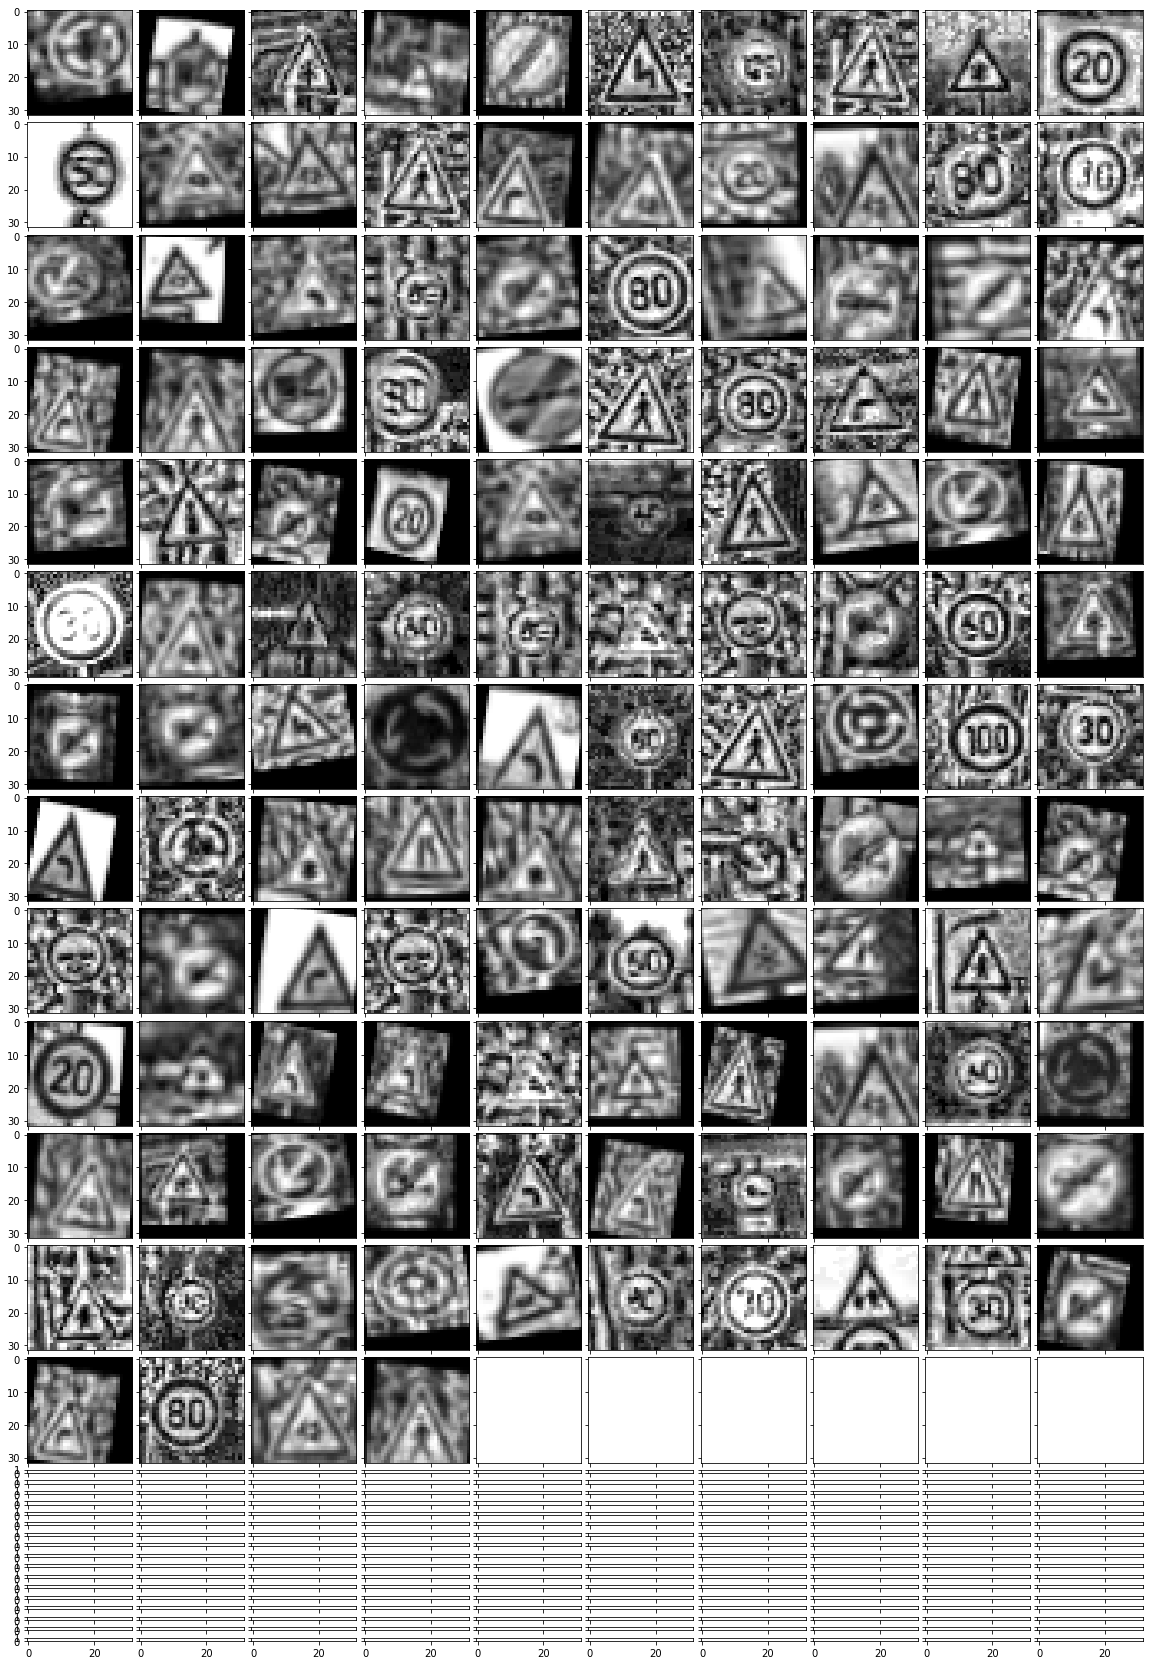

In [300]:
print("validation error image labels")
#print(debugger_valid_labels)

num_debugger = np.asarray(debugger_valid_labels)

#print(num_debugger.shape[0])

for i in range((math.ceil((num_debugger.shape[0])/10))):
    
    offset = i * 10
    print(num_debugger[offset:offset+10])


fig = plt.figure(1, (30., 30.))

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(30, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                  )

for index, image in enumerate(debugger_valid_images):
    gray = image.reshape(32,32)
    grid[index].imshow(gray, cmap="gray")
#    show_image(gray, cmap="gray")

plt.show()

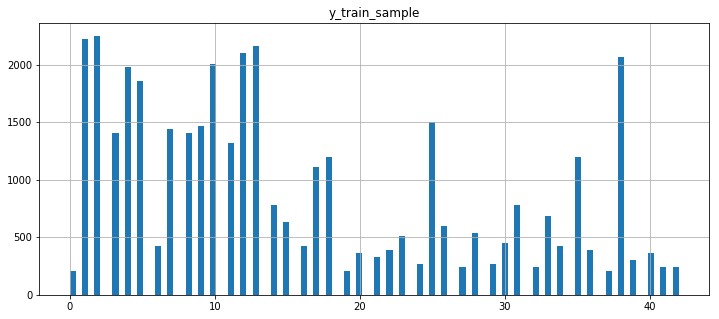

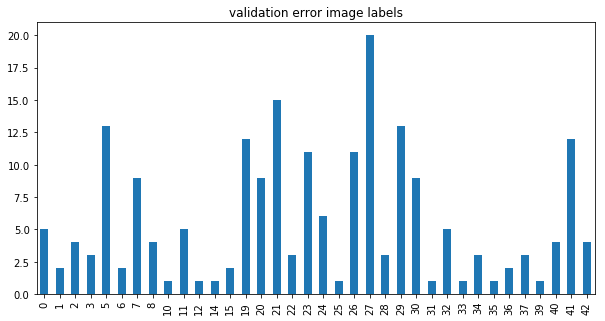

In [290]:
from collections import Counter
import operator
import matplotlib.pyplot as plt

distribution =pd.DataFrame({"y_train_sample":y_train})
distribution.hist(layout=(1,1),bins=100, figsize=(12,5))  

debugger_dic =  Counter(debugger_valid_labels)

#plt.bar(range(len(debugger_dic)), debugger_dic.values(), align='center')
#plt.xticks(range(len(debugger_dic)), debugger_dic.keys())
#plt.show()

df = pd.DataFrame([debugger_dic])
df = df.T

fig, axes = plt.subplots(nrows=1, ncols=1)
for i,c in enumerate(df.columns):
    df[c].plot(kind='bar',  figsize=(10, 5), title="validation error image labels")

[11  2 38 15 40]


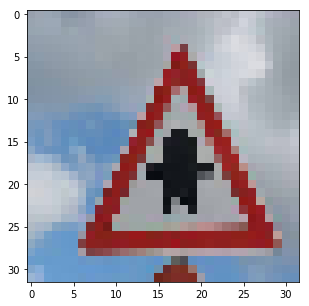

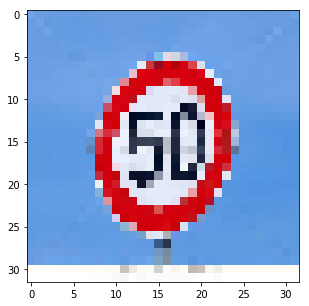

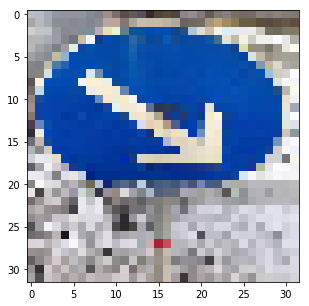

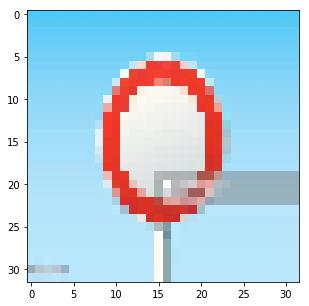

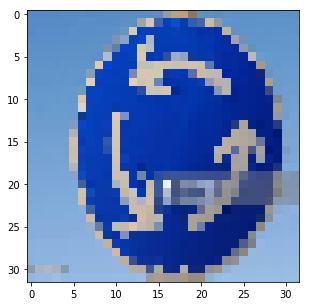

In [90]:
imagedir = "./data/"

X_web,y_web = load_resized_images_in_directory(32,32,imagedir)

print(y_web)

show_image(X_web[0])
show_image(X_web[1])
show_image(X_web[2])
show_image(X_web[3])
show_image(X_web[4])

#resize = resize_image(X_web[0],33,33) 

#show_image(resize)

In [91]:
imagedir = "./data/"

data_web,y_web = load_resized_images_in_directory(32,32,imagedir)

In [92]:
X_web,_ = convert_gray_with_adapthist(data_web)

y is None


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [94]:
# restoring and (trainning and saving trained model) again

EPOCHS_WEB = 1


with tf.Session() as sess:
    sess.run(init)
    
    saver.restore(sess, "./lenet/model.ckpt")
       
    print("restored...")
    
    num_examples = len(X_web)
    
    for i in range(EPOCHS_WEB):

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_web[offset:end], y_web[offset:end]
            print(batch_y)

        if(i == (EPOCHS_WEB-1) ):
            test_loss, test_accuracy = evaluate(X_web, y_web)
          
            print("EPOCH {} ...".format(i+1))
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            
            topk_values, topk_indices = evaluate_topk(X_web, y_web)
            print(topk_values)
            print(topk_indices)


restored...
[11  2 38 15 40]
EPOCH 1 ...
Test Accuracy = 0.400
[[ 0.27160704  0.0581399   0.04620881  0.04573818  0.03018127]
 [ 0.13688949  0.05629095  0.0367832   0.03580752  0.0300195 ]
 [ 0.0629276   0.04526407  0.04007246  0.04002387  0.03314662]
 [ 0.12207513  0.07634555  0.03628379  0.03135892  0.03021281]
 [ 0.18763804  0.03639283  0.03512758  0.03082893  0.02686206]]
[[30 11 24 28 21]
 [ 5  8  7  2 40]
 [11 13 38 25 31]
 [15 34 22 12 36]
 [40 38 12  7 10]]


In [96]:
no_node_web = [n.name for n in tf.get_default_graph().as_graph_def().node]

In [97]:
#len([i for i, j in zip( no_node_training, no_node_debugger) if i == j])
len([i for i, j in zip( no_node_training, no_node_web) if i == j])

608

In [95]:
print_tensors_in_checkpoint_file("./lenet/model.ckpt",tensor_name='')

b1 (DT_FLOAT) [16]
b1/Adam (DT_FLOAT) [16]
b1/Adam_1 (DT_FLOAT) [16]
b2 (DT_FLOAT) [32]
b2/Adam (DT_FLOAT) [32]
b2/Adam_1 (DT_FLOAT) [32]
beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
fc1_b1 (DT_FLOAT) [1200]
fc1_b1/Adam (DT_FLOAT) [1200]
fc1_b1/Adam_1 (DT_FLOAT) [1200]
fc1_w1 (DT_FLOAT) [6144,1200]
fc1_w1/Adam (DT_FLOAT) [6144,1200]
fc1_w1/Adam_1 (DT_FLOAT) [6144,1200]
fc2_b2 (DT_FLOAT) [43]
fc2_b2/Adam (DT_FLOAT) [43]
fc2_b2/Adam_1 (DT_FLOAT) [43]
fc2_w2 (DT_FLOAT) [1200,43]
fc2_w2/Adam (DT_FLOAT) [1200,43]
fc2_w2/Adam_1 (DT_FLOAT) [1200,43]
w1 (DT_FLOAT) [3,3,1,16]
w1/Adam (DT_FLOAT) [3,3,1,16]
w1/Adam_1 (DT_FLOAT) [3,3,1,16]
w2 (DT_FLOAT) [3,3,16,32]
w2/Adam (DT_FLOAT) [3,3,16,32]
w2/Adam_1 (DT_FLOAT) [3,3,16,32]



In [58]:
traffic_signs = pd.read_csv("signnames.csv")
traffic_signs

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


(32, 32, 1)


(array([  3.,  10.,   8.,   4.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 0.02148438,  0.06920856,  0.11693274,  0.16465693,  0.21238111,
         0.2601053 ,  0.30782948,  0.35555367,  0.40327785,  0.45100204,
         0.49872622,  0.54645041,  0.59417459,  0.64189878,  0.68962296,
         0.73734715,  0.78507133,  0.83279552,  0.8805197 ,  0.92824389,
         0.97596807,  1.02369226,  1.07141644,  1.11914062]),
 <a list of 23 Patch objects>)

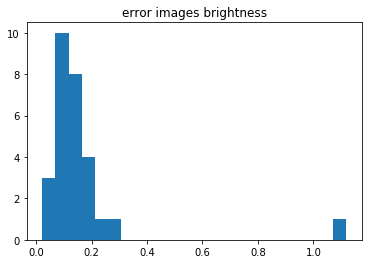

In [61]:
# bright pixels = number of pixles whose value is greater than cutoff, eg.0.9.
# bright pixels / image size (rows * cols)

print(error_images[0].shape)

def cal_portion_brightness(images, cutoff=0.8):
    
    data_list = []
#    for index, image in enumerate(debugger_valid_images):
    for index, image in enumerate(images):
        gray = image.reshape(32,32)
        rows, cols = np.where(gray.reshape(32,32) > cutoff)
        debugger_sum = rows.shape[0]+cols.shape[0]
        data = debugger_sum/(32*32)
    
        data_list.append(data)
#    print(data_list)
    
    return data_list

brightness = cal_portion_brightness(debugger_valid_images ,cutoff=0.85)


error_images_brightness = np.asarray(brightness)

plt.title("error images brightness")
plt.hist(error_images_brightness.flatten(), bins='auto')

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

In [ ]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
#assert X_train.shape == data['features'].shape, 'X_train has changed shape. The shape shouldn\'t change when shuffling.'
#assert y_train.shape == data['labels'].shape, 'y_train has changed shape. The shape shouldn\'t change when shuffling.'

assert round(X_valid.shape[0]/n_train,2) == 0.2, 'X_train not splitted'
assert round(y_valid.shape[0]/n_train,2) == 0.2, 'y_train not splitted'
assert not np.array_equal(X_train, data['features']), 'X_train not shuffled.'
assert not np.array_equal(y_train, data['labels']), 'y_train not shuffled.'
print('Tests passed.')

1. shuffling
2. gray conversion
3. LeNet-5 architecture from the course
4. model layer evaluation (run each model whenever layer is added.)

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

implemented during 'exploratory visualization of the dataset' above 
: def normalize_grayscale(image_data, scale=1)

### Model Architecture

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

### Predict the Sign Type for Each Image

### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In [ ]:
"""

from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('train.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Train Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/train.p',
            'train.p',
            pbar.hook)

if not isfile('test.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Test Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/test.p',
            'test.p',
            pbar.hook)

print('Training and Test data downloaded.')

"""

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

In [ ]:
"""
data = load_pickle('train.p')

# TODO: Load the feature data to the variable X_train
X_train = data['features']
# TODO: Load the label data to the variable y_train
y_train = data['labels']

test = load_pickle('test.p')
X_test = test['features']
y_test = test['labels']

print('Training and Test data loaded.')
"""

In [ ]:
"""
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("number of classes ", n_classes)
#print("coords_train =", coords_train)
#print("size_train =", size_train)
"""

In [ ]:
"""

imagedir = "./data/"

X_web,y_web = load_images_in_directory(imagedir)

print(X_web.shape)

show_image(X_web[1])

resize = resize_image(X_web[0],33,33) 

show_image(resize)

"""

In [ ]:
"""
fakes_label = make_fakes_labels(y_train,5)
print("fake labels - image label list, %s" % len(fakes_label))
print(fakes_label[0])
print(fakes_label[4])
print(fakes_label[190000])
print(fakes_label[190004])

y_train_norm = list_to_numpy(fakes_label)
print("numpy array converted from list, %s" % str(y_train_norm.shape))

save_pickle(y_train_norm,"y_train_norm.p")

label_norm = load_pickle('y_train_norm.p')
print(label_norm["features"].shape)
"""

In [ ]:
"""
fakes = make_fakes(X_train,5)
print("fakes - image list, %s" % len(fakes))

X_train_norm = list_to_numpy(fakes)
print("numpy array converted from list, %s" % str(X_train_norm.shape))

save_pickle(X_train_norm,"train_norm.p")

data_norm = load_pickle('train_norm.p')
print(data_norm["features"].shape)
"""

In [ ]:
"""
show_image(data_norm["features"][0])
show_image(data_norm["features"][3])
show_image(data_norm["features"][2])
"""